# Fachprojekt Machine Learning
Authors: Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 12. June 2024

## Import necessary components

In [7]:
# Import the necessary libraries
import time
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the VAE model and functions
import networks
from datasets import create_datasets
from evaluation import evaluate
from sampling import sample, plot_reconstruction

## Set hyperparameters, loss function and optimizing tools

In [8]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 75 # One epoch means seeing every image of the training datasetSS
latent_dim = 256  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
learning_rate = 5e-5 # Determines how drastically the parameters of the network change

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VAE(input_channels, latent_dim)
model.to(device)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.0001*KLD

# Optimizer selection
optimizer_option = 'adamw'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'cosine'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cpu


## Choose a dataset for training

Files already downloaded and verified
Files already downloaded and verified


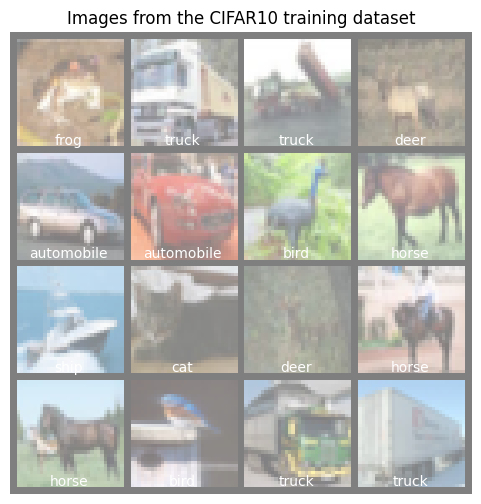

In [9]:
# Create and visualize the datasets for MNIST / CIFAR10
dataset_name = 'CIFAR10'
train_loader, test_loader = create_datasets(dataset_name, batch_size)

## Training loop

In [ ]:
# We want to plot training and testing losses at the end of training
train_losses = []
test_losses = []
learning_rates = []

# Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_start_time = time.time()

  for _, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()

    with torch.cuda.amp.autocast():
      # Forward pass
      recon_batch, mu, logvar = model(data)

      # Compute loss
      loss = loss_function(recon_batch, data, mu, logvar)
      train_losses.append(loss)

    # Backward pass
    scaler.scale(loss).backward()

    # Optimization step
    scaler.step(optimizer)
    scaler.update()

    # Ivan: add logging here

  # Step the learning rate scheduler
  if scheduler is not None:
    lr = scheduler.get_last_lr()[0]
    scheduler.step()
  else:
    lr = learning_rate
  learning_rates.append(lr)

  # After the epoch, evaluate the accuracy on the test dataset
  mean_loss = evaluate(model, test_loader, loss_function, device)
  test_losses.append(mean_loss)

  elapsed_time = time.time() - epoch_start_time
  print(f'Epoch {epoch + 1}, Mean Test Loss: {mean_loss}, Learning Rate: {lr:.6f}, Time: {elapsed_time:.2f}s')

  # Generate and log test images after each epoch
  plot_reconstruction(model, test_loader, device, num_samples=5)
  print('---------------------------------------------------------------------------------------------------')

# Ivan: add plots here

# Sample some VAE-generated images
sample(model, device, latent_dim, num_samples=50)